##   <font color='Lime'>Import libraries</font> 

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras


In [3]:
#!pip install tf-nightly
#!pip install keras_efficientnets

## <font color='Aquamarine'>Create labels</font> 

In [4]:
#create labels
classes=[]
filename=r"C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## <font color='Aquamarine'>Resize images and put together Training and Testing folder</font> 

In [5]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 74/74 [00:00<00:00, 133.38it/s]


## <font color='Aquamarine'>Data augmentation</font> 

In [6]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

In [7]:
print(y_train)
#from keras.applications.efficientnet_v2 import EfficientNetV2M
#%%%
#from keras.applications.efficientnet import EfficientNetV2M
#load EfficientNet
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]


## <font color='Aquamarine'>Train the model</font> 

In [21]:
#train the model
tf.random.set_seed(77)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.35)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.00025,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=7,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=11,callbacks=[early_stopping_cb])


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 160, 160, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 160, 160, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization_3[0][0]            
____________________________________________________________________________________________

253/253 [==============================] - 67s 210ms/step - loss: 0.6954 - accuracy: 0.7257 - val_loss: 0.3785 - val_accuracy: 0.8449
Epoch 2/70
253/253 [==============================] - 129s 512ms/step - loss: 0.3404 - accuracy: 0.8792 - val_loss: 0.3303 - val_accuracy: 0.8878
Epoch 3/70
253/253 [==============================] - 129s 510ms/step - loss: 0.2447 - accuracy: 0.9095 - val_loss: 0.1743 - val_accuracy: 0.9429
Epoch 4/70
253/253 [==============================] - 129s 510ms/step - loss: 0.1561 - accuracy: 0.9474 - val_loss: 0.1158 - val_accuracy: 0.9612
Epoch 5/70
253/253 [==============================] - 130s 513ms/step - loss: 0.1232 - accuracy: 0.9593 - val_loss: 0.0869 - val_accuracy: 0.9694
Epoch 6/70
253/253 [==============================] - 130s 516ms/step - loss: 0.0862 - accuracy: 0.9733 - val_loss: 0.2059 - val_accuracy: 0.9388
Epoch 7/70
253/253 [==============================] - 130s 514ms/step - loss: 0.0920 - accuracy: 0.9730 - val_loss: 0.1169 - val_accurac

In [22]:
y_train.shape,y_test.shape

((2774,), (490,))

## <font color='Aquamarine'>Save the model</font> 

C:\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification


C:\Users\diego\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


16/16 [==============================] - 12s 519ms/step - loss: 0.0549 - accuracy: 0.9816
Accuracy: 98.163265


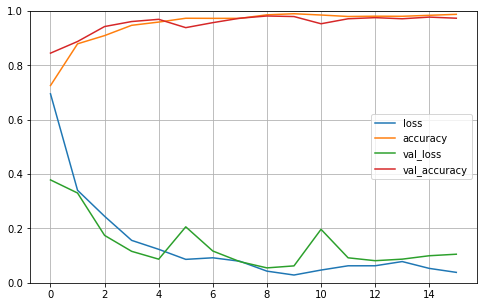

In [23]:
# change directory
os.chdir(r'C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification')
print(os.getcwd())

#save the model
model.save(os.path.join('models/','EfficientNetB3.h5'))
model.save_weights(os.path.join('models/','EfficientNetB3_weights.h5'))

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
plt.savefig(os.path.join('plots/','EfficientNetB3.png'), dpi=500)
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

## <font color='Aquamarine'>Load the model </font> 

In [7]:
 #load the model
model=keras.models.load_model(os.path.join('models/','EfficientNetB3.h5'))   
#  More details about the model
#model.summary()
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 49s 522ms/step - loss: 0.0549 - accuracy: 0.9816


In [114]:
# visualize activation functions
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')
#specific info about each layer
for i in range(len(model.layers)):
    print(f'{i}   {model.layers[i]}: \n{model.layers[i].get_config()} \n')
#info about optimizers
model.optimizer.get_config()  

0 <keras.engine.input_layer.InputLayer object at 0x00000230FF34F3D0>
   no activation attribute
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000002309C8CFC40>
   no activation attribute
2 <keras.layers.preprocessing.normalization.Normalization object at 0x000002309C8CFDC0>
   no activation attribute
3 <keras.layers.convolutional.ZeroPadding2D object at 0x000002309C8CFA30>
   no activation attribute
4 <keras.layers.convolutional.Conv2D object at 0x000002309C949190>
     <function linear at 0x00000230FF252C10>
5 <keras.layers.normalization_v2.BatchNormalization object at 0x000002309C949760>
   no activation attribute
6 <keras.layers.core.Activation object at 0x000002309C8CFBE0>
     <function swish at 0x00000230FF252430>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000230F02C8670>
     <function linear at 0x00000230FF252C10>
8 <keras.layers.normalization_v2.BatchNormalization object at 0x00000230FF2AE040>
   no activation attribute
9 <keras.layer

74   <keras.layers.normalization_v2.BatchNormalization object at 0x000002309C9D0880>: 
{'name': 'block3a_expand_bn', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None} 

75   <keras.layers.core.Activation object at 0x000002309C9D0CA0>: 
{'name': 'block3a_expand_activation', 'trainable': True, 'dtype': 'float32', 'activation': 'swish'} 

76   <keras.layers.convolutional.ZeroPadding2D object at 0x000002309C9D0D90>: 
{'name': 'block3a_dwconv_pad', 'trainable': True, 'dtype': 'float32', 'padding': ((1, 2), (1, 2)), 'data_format': 'channels_last'} 

77   <keras


231   <keras.layers.normalization_v2.BatchNormalization object at 0x000002309CA89A60>: 
{'name': 'block5c_project_bn', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None} 

232   <keras.layers.core.Dropout object at 0x000002309CA89EE0>: 
{'name': 'block5c_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.11538461538461539, 'noise_shape': ListWrapper([None, 1, 1, 1]), 'seed': None} 

233   <keras.layers.merge.Add object at 0x000002309CA89F10>: 
{'name': 'block5c_add', 'trainable': True, 'dtype': 'float32'} 

234   <keras.layers.convolutional.Conv2D ob

{'name': 'Adam',
 'learning_rate': 0.00025,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False}

## <font color='Aquamarine'>Accuracy and Loss</font> 

In [10]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 98.163 
 loss : 0.055


In [49]:
#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)
pred_labels

array(['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor',
       'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor',
       'glioma_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor',
       'meningioma_tumor', 'meningioma_tumor', 'no_tumor',
       'meningioma_tumor', 'pituitary_tumor', 'glioma_tumor',
       'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor',
       'meningioma_tumor', 'pituitary_tumor', 'glioma_tumor',
       'pituitary_tumor', 'no_tumor', 'glioma_tumor', 'glioma_tumor',
       'meningioma_tumor', 'pituitary_tumor', 'no_tumor', 'glioma_tumor',
       'glioma_tumor', 'glioma_tumor', 'pituitary_tumor',
       'meningioma_tumor', 'no_tumor', 'pituitary_tumor',
       'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor',
       'pituitary_tumor', 'no_tumor', 'meningioma_tumor',
       'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor',
       'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor',
       'glioma_tumor', 'meningioma

In [103]:
import matplotlib.image as mpimg
os.chdir(r'C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification')
filename=r"C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data"
VALIDATION_DIR=os.path.join(filename,'Testing')

#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(VALIDATION_DIR)): 
    dir_fold=os.path.join(VALIDATION_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]
#valid for balanced classes



C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data\Testing\glioma_tumor
C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data\Testing\meningioma_tumor
C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data\Testing\no_tumor
C:\\Users\diego\OneDrive\Desktop\DS\brain_cancer\Brain_cancer_classification\data\Testing\pituitary_tumor


In [109]:
print(classes)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


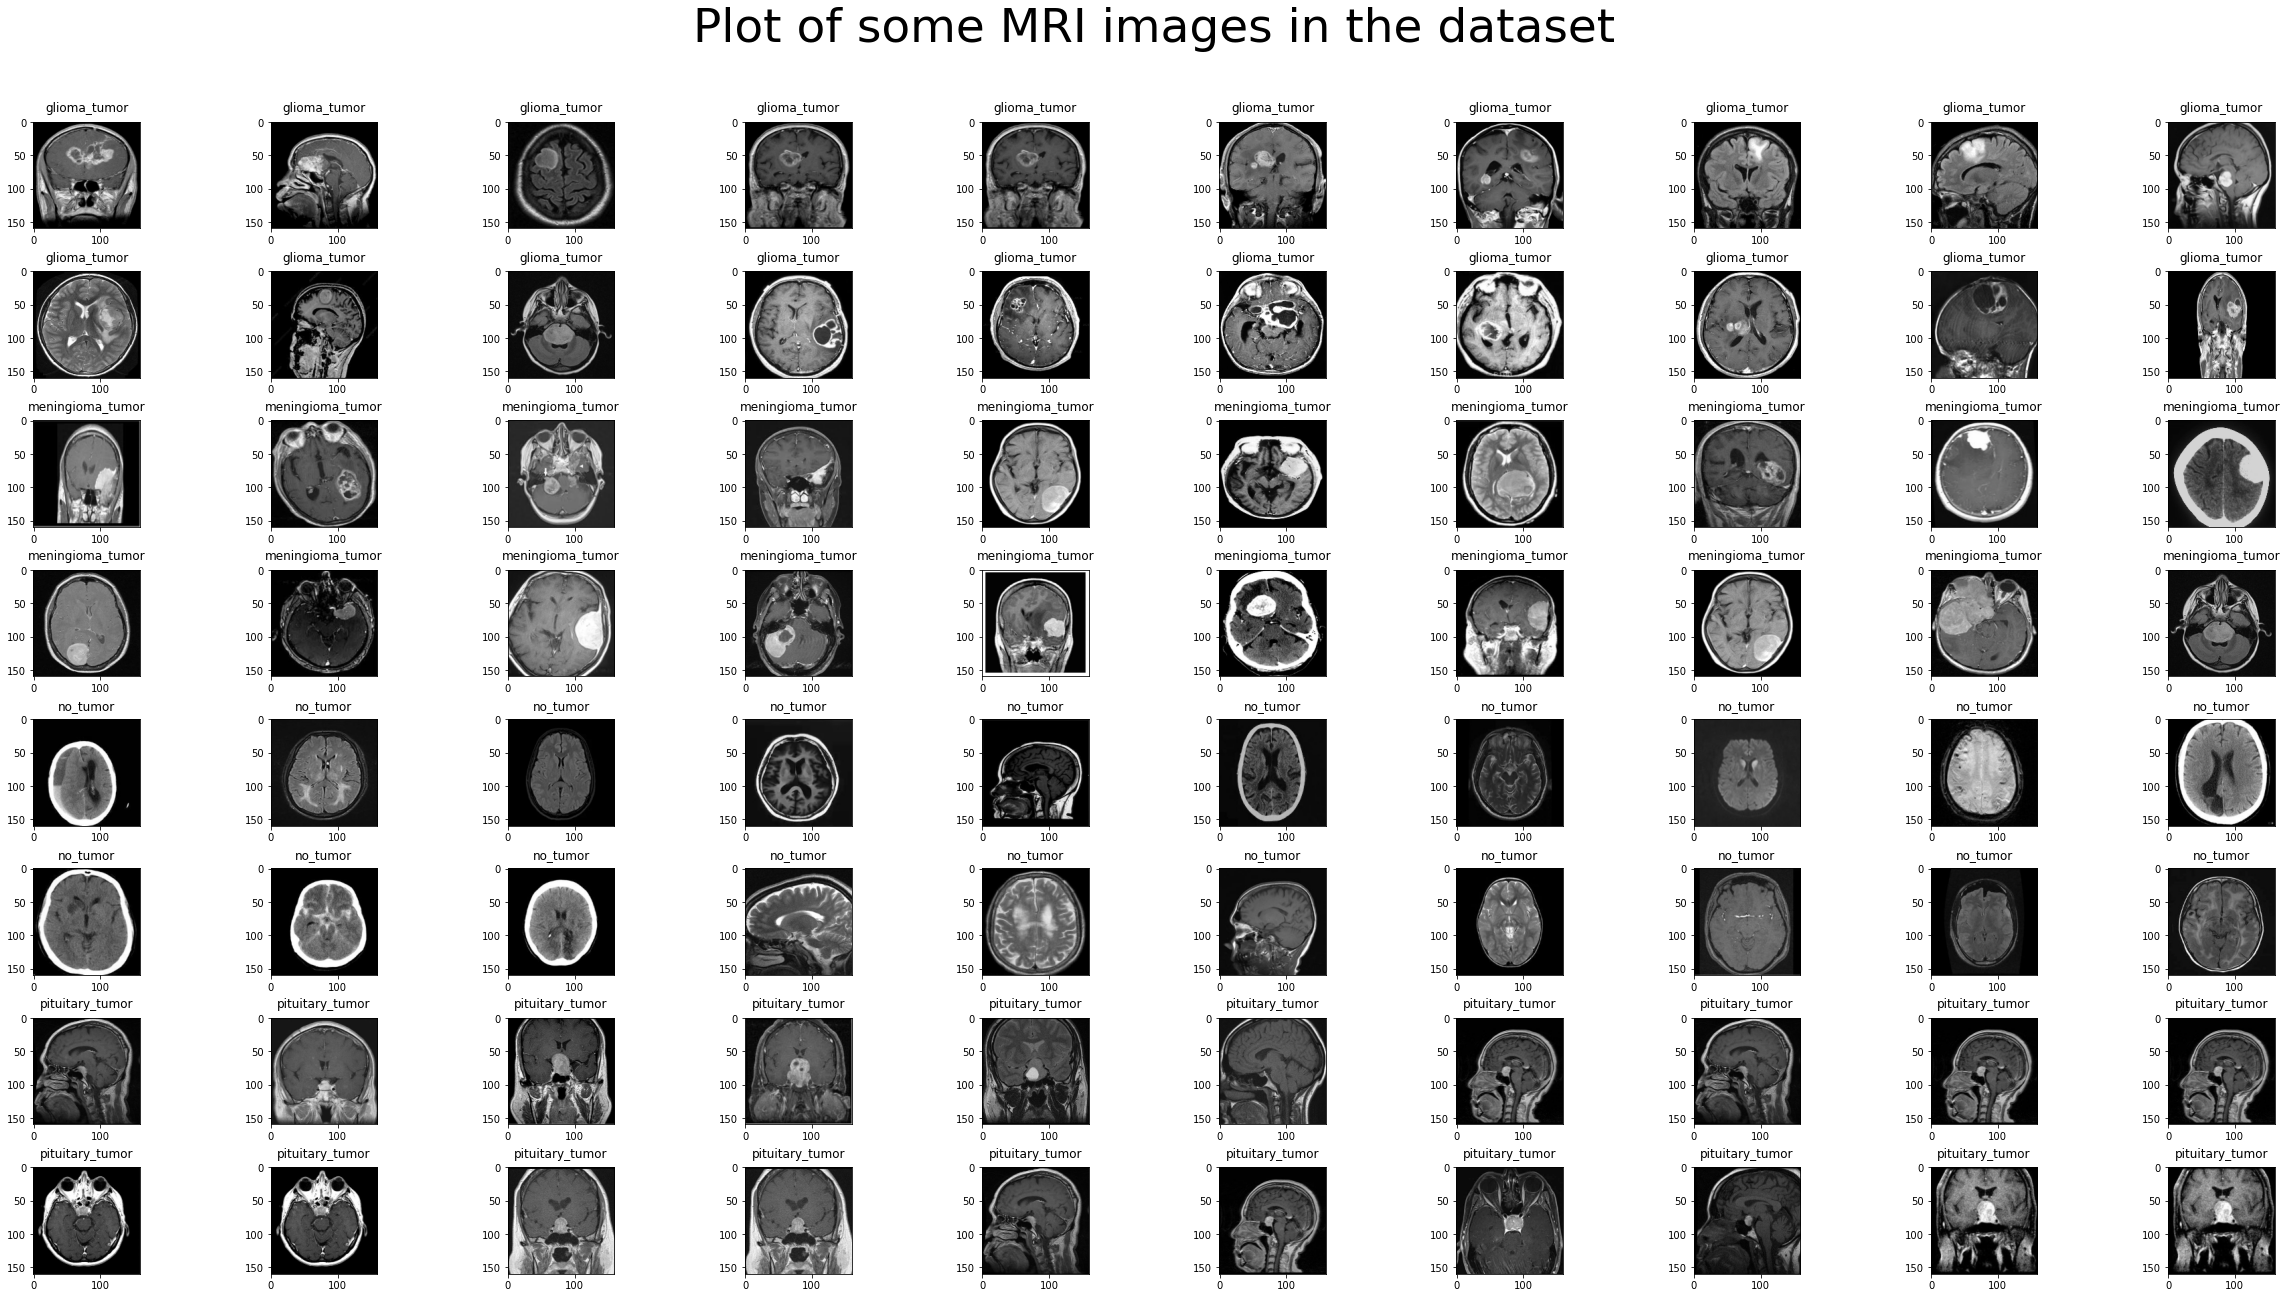

In [111]:
#here I plotted the images based on columns and z_max (defined by the user, but it should be a multiple of the n. of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')

In [132]:
X_test_images=dict(zip(classes,[[],[],[],[]]))
for y,ele in enumerate(pred):
    for i,x in enumerate(X_test_images):
        #num=pred[ind]
        if ele==i:
            if len(X_test_images[classes[i]])<z_max:
                X_test_images[classes[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]


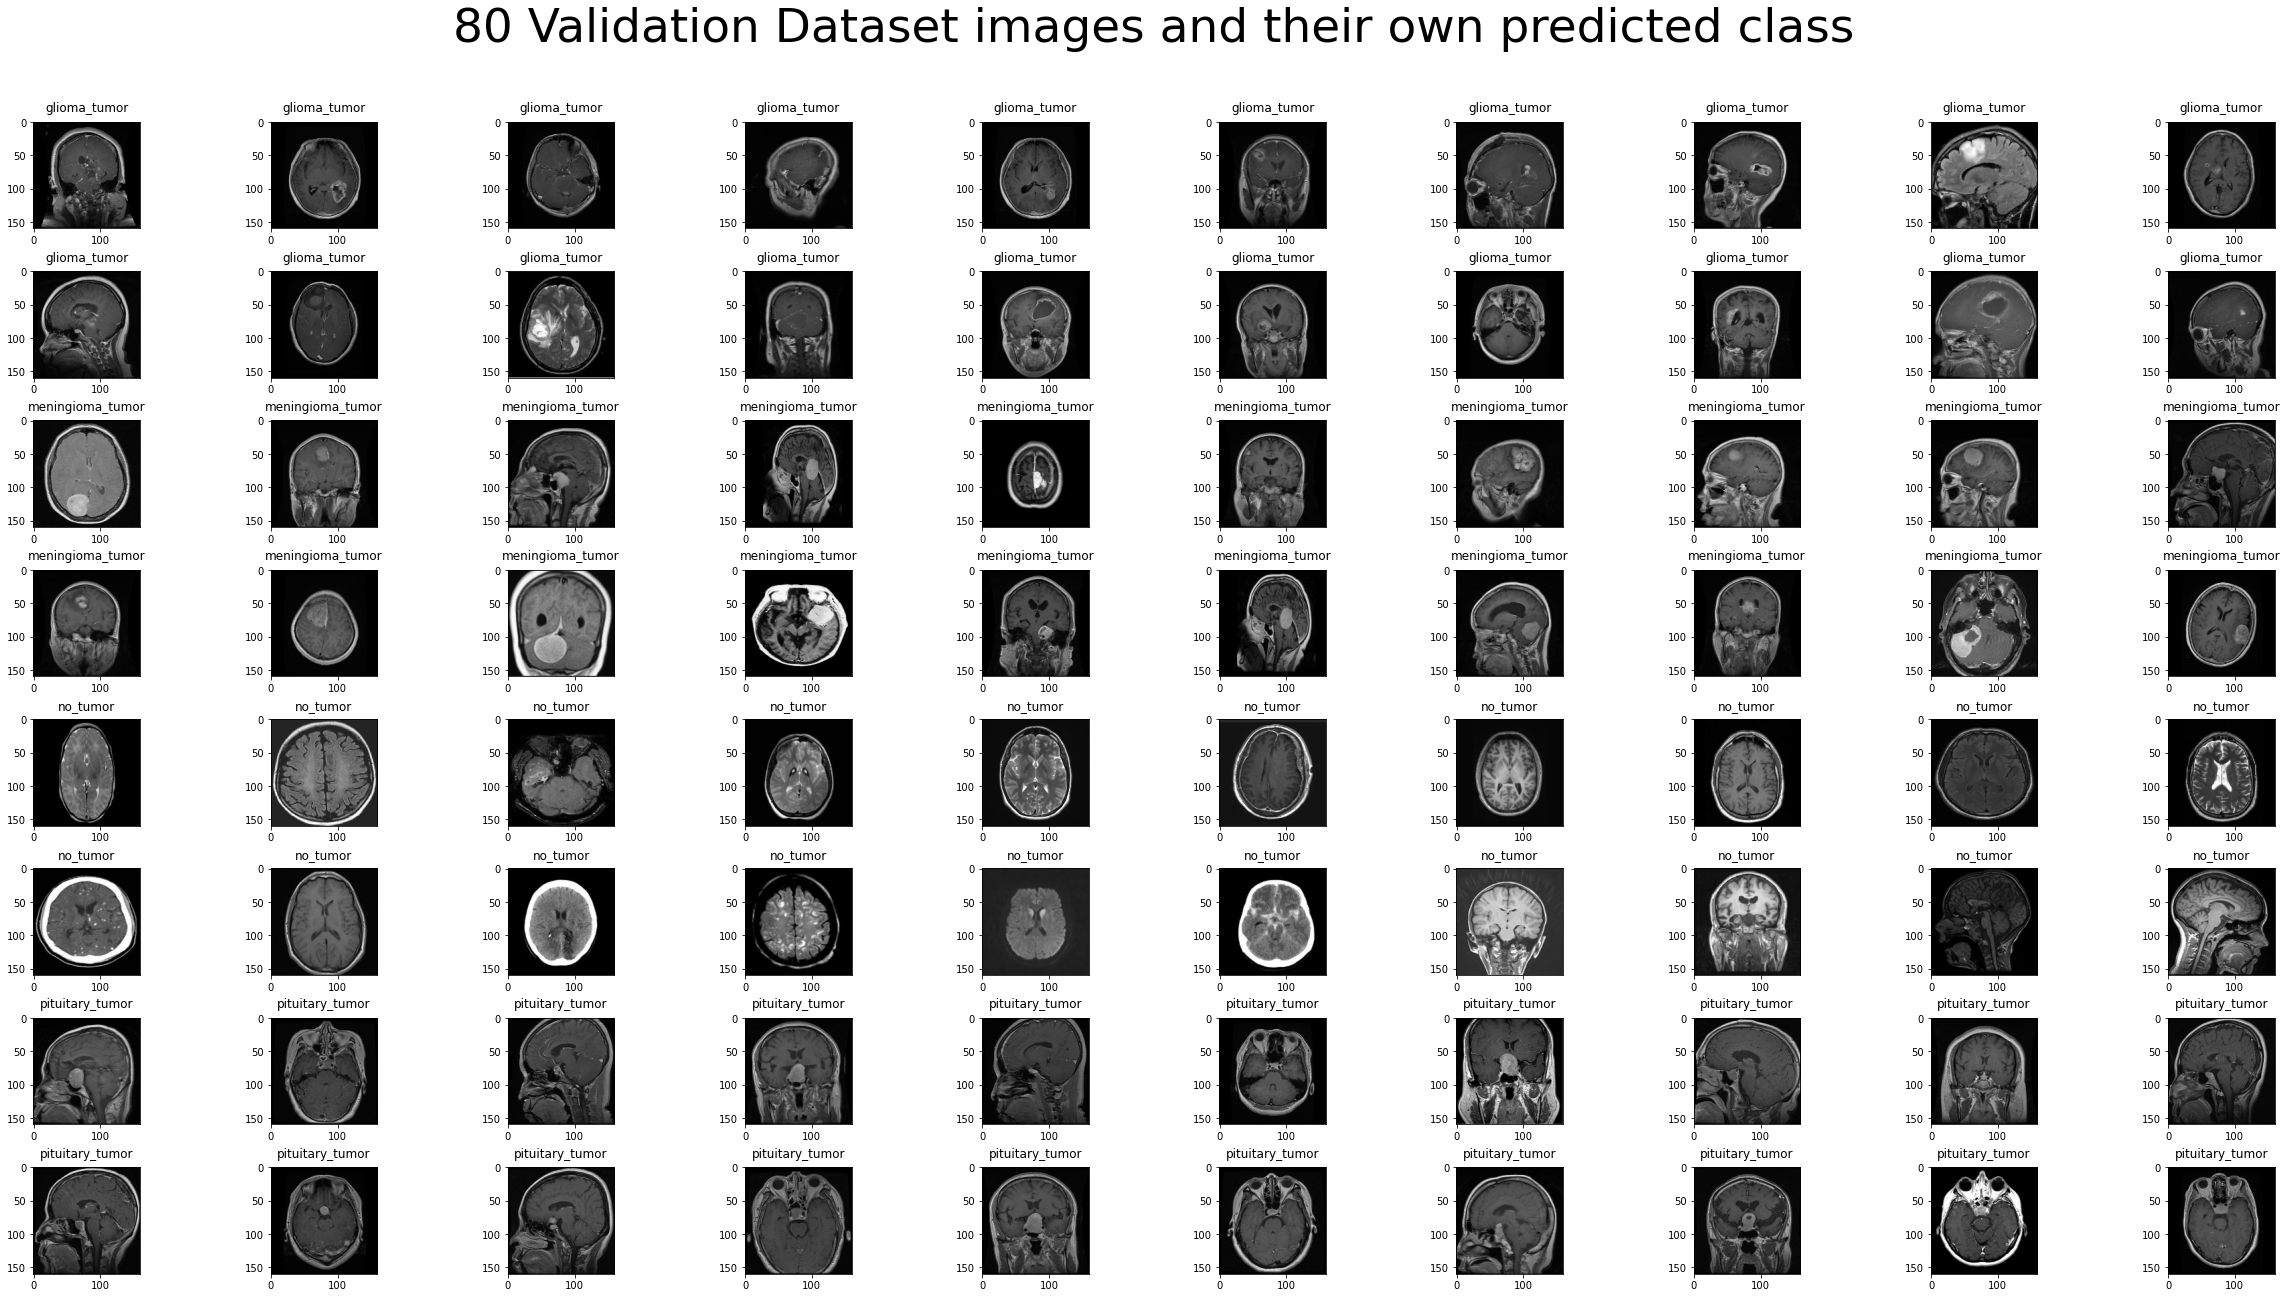

In [136]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    #print(images_class)
    fig.suptitle('80 Validation Dataset images and their own predicted class',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass.png'), dpi=300)
#plt.savefig(os.path.join('plots/','80ValidationDatasetimages_and_predictedclass_white.png'), dpi=300,facecolor='w')

In [119]:
X_test.shape

(490, 160, 160, 3)